# PAI Scoring on radiographs

## Data
Radiographs are provided as 8 bit grayscale image clips 256x256 pixels centered on the apex. Each file has a label with the PAI scored by a human person. Later we will add on weigthtings for the humans compentence level because some scorings are done by undergraduate dentistry students.

## Todo
This version works on a limited set by one specialist candidate and overperforms. Have to change it to use the bigger database we have available with more thant 2 000 examples.

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Do not show warnings

In [14]:
system = "jupyter"
data = "deniz"

# specify your directory and CSV file paths
if system == "linux":
    data_dir = "/fp/homes01/u01/ec-gerald/My Projects/ec192/data/endo-radiographs/clips"
elif system == "win":
    data_dir = r"\\aspasia.ad.fp.educloud.no\ec192\data\endo-radiographs\clips"
elif system == "jupyter":
    if data == "dag":
        data_dir = "/fp/projects01/ec192/data/endo-radiographs/dag/clips"
    elif data == "deniz":
        data_dir = "/fp/projects01/ec192/data/endo-radiographs/deniz/clips"
        
    
    
csv_file = os.path.join(data_dir, "codefile.csv")

image_size = 256

# load the CSV file using pandas
df = pd.read_csv(csv_file)
df.columns = ['filename', 'prediction']

# convert labels to str because ImageDataGenerator treats all inputs as strings
df['prediction'] = df['prediction'].astype(str)

# split the data into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# specify your target image size (this will be the input shape for your CNN)
target_size = (image_size, image_size)

In [15]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))  # output layer with 5 nodes

    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# create the model
model = create_model()

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 262144)            0

2023-07-04 11:23:55.162167: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
# specify batch size
batch_size = 64  

# create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="filename",  # this might be "image_name" or something similar depending on your CSV
    y_col='prediction',  # this might be "diagnosis" or something similar depending on your CSV
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # use 'categorical' since we have now one-hot encoded labels
    color_mode='grayscale'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=data_dir,
    x_col="filename",  # this might be "image_name" or something similar depending on your CSV
    y_col='prediction',  # this might be "diagnosis" or something similar depending on your CSV
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # use 'categorical' since we have now one-hot encoded labels
    color_mode='grayscale'
)

Found 285 validated image filenames belonging to 5 classes.
Found 72 validated image filenames belonging to 5 classes.


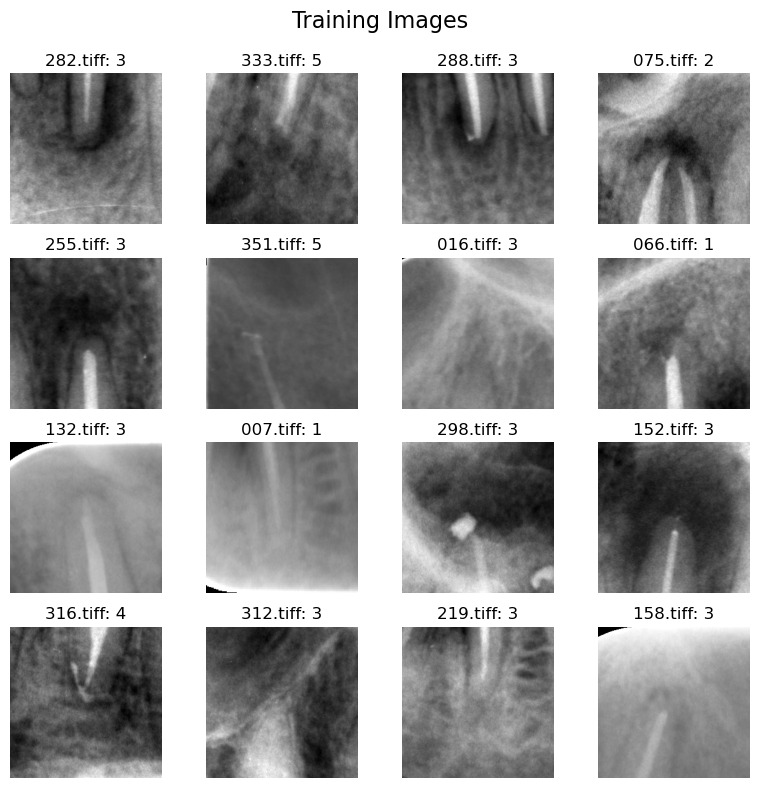

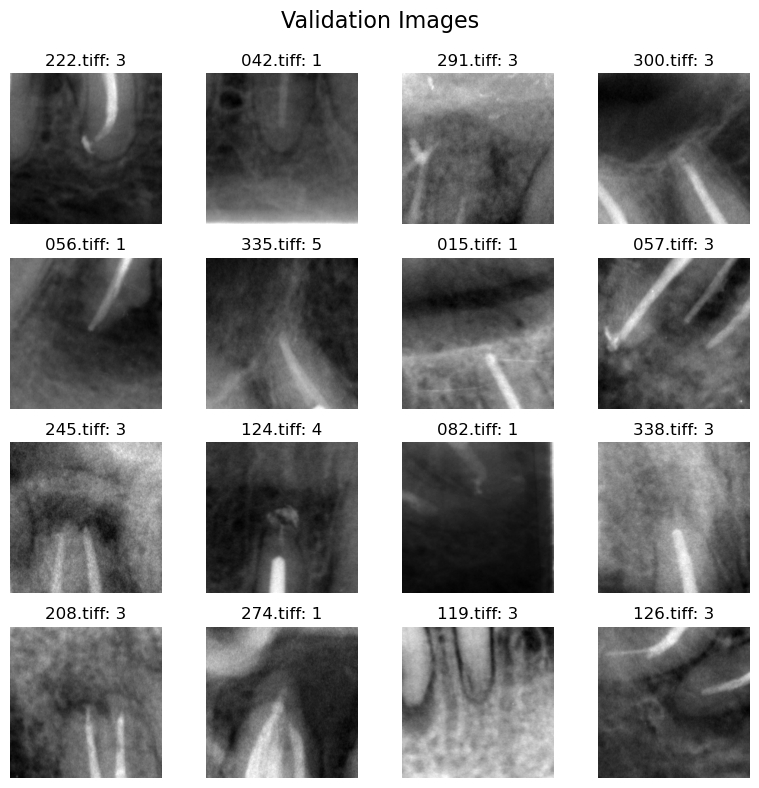

In [17]:
# Visualize data:
%matplotlib inline

# Function to get filenames from the generator
def get_filenames(generator):
    return generator.filenames

# Function to get class indices
def get_class_indices(generator):
    return generator.classes

# Fetch filenames and class indices for training and validation sets
train_filenames = get_filenames(train_generator)
train_class_indices = get_class_indices(train_generator)

valid_filenames = get_filenames(valid_generator)
valid_class_indices = get_class_indices(valid_generator)

# Get the class labels from class indices
label_map = (train_generator.class_indices)
inverse_label_map = {v: k for k, v in label_map.items()}

train_labels = [inverse_label_map[index] for index in train_class_indices]
valid_labels = [inverse_label_map[index] for index in valid_class_indices]

# Modified plot function to include file names and labels
def plot_images_with_labels(images, filenames, labels, title):
    fig, axes = plt.subplots(4, 4, figsize=(8,8))
    axes = axes.ravel()

    for i in np.arange(0, 16):
        axes[i].imshow(images[i].reshape(target_size), cmap='gray')
        axes[i].set_title(f"{filenames[i]}: {labels[i]}")
        axes[i].axis('off')
        #print(filenames[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # adjust the top spacing
    plt.suptitle(title, fontsize=16)  # use suptitle for better positioning
    plt.show()

# Plot images with labels
train_images, _ = next(train_generator)  # Get a batch of images from the generator
valid_images, _ = next(valid_generator)

plot_images_with_labels(train_images, train_filenames, train_labels, 'Training Images')
print("\n\n")
plot_images_with_labels(valid_images, valid_filenames, valid_labels, 'Validation Images')

In [18]:
# Train the model
epochs = 20

# Define the checkpoint and early stopping
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,  # steps_per_epoch should typically be equal to the total number of samples divided by the batch size
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps= len(valid_df) // batch_size,  # similar rule as steps_per_epoch but for the validation data
    callbacks=[early]
)


# Save model with timestamp
model.save(f"../../../saved_models/my_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5")

Epoch 1/20


2023-07-04 11:24:17.763684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - ETA: 0s - loss: 1.3894 - accuracy: 0.4751

2023-07-04 11:24:21.763682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 4s 819ms/step - loss: 1.3894 - accuracy: 0.4751 - val_loss: 1.2266 - val_accuracy: 0.6562
Epoch 2/20
4/4 [==============================] - 4s 908ms/step - loss: 1.3046 - accuracy: 0.6523 - val_loss: 1.1517 - val_accuracy: 0.6406
Epoch 3/20
4/4 [==============================] - 3s 767ms/step - loss: 1.2084 - accuracy: 0.6471 - val_loss: 1.2119 - val_accuracy: 0.6094
Epoch 4/20
4/4 [==============================] - 4s 874ms/step - loss: 1.2013 - accuracy: 0.6484 - val_loss: 1.1483 - val_accuracy: 0.6406
Epoch 5/20
4/4 [==============================] - 3s 778ms/step - loss: 1.2018 - accuracy: 0.6697 - val_loss: 1.2114 - val_accuracy: 0.5938
Epoch 6/20
4/4 [==============================] - 3s 732ms/step - loss: 1.1307 - accuracy: 0.6742 - val_loss: 1.0815 - val_accuracy: 0.6562
Epoch 7/20
4/4 [==============================] - 3s 850ms/step - loss: 1.1064 - accuracy: 0.6652 - val_loss: 1.1042 - val_accuracy: 0.6250
Epoch 8/20
4/4 [===============

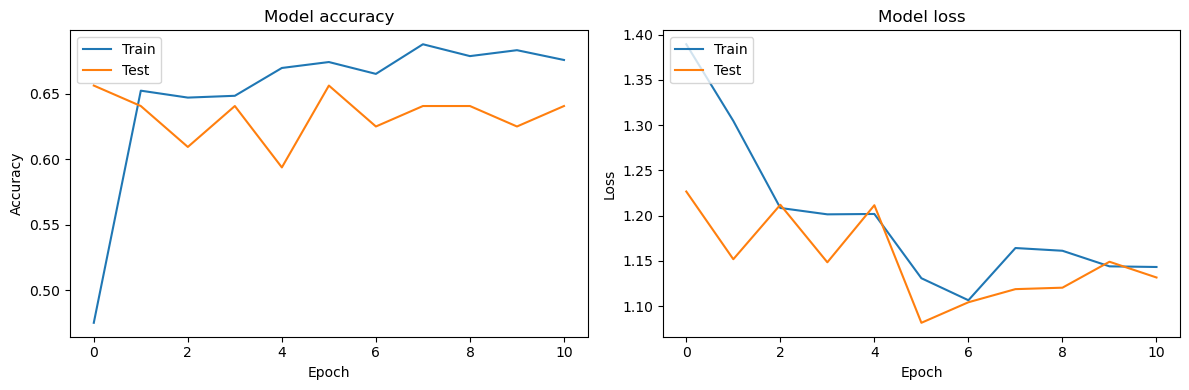

In [19]:
%matplotlib inline

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# For testing the system

#file_path = input("Please enter the path to your file: ")

# /fp/projects01/ec192/data/endo-radiographs/deniz/anonymized/002.tiff

# Now you can use the `file_path` variable to load your file
# For example, to load an image with matplotlib:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
#img = mpimg.imread(file_path)
#imgplot = plt.imshow(img)
#plt.show()